TasmanianSG version: 4.0
TasmanianSG license: BSD 3-Clause
Fixed Sparse Grids


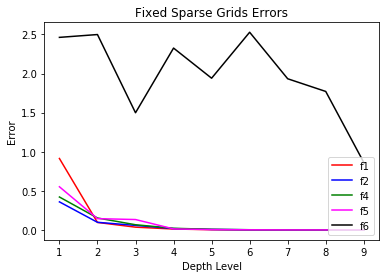

In [20]:
# Exercise 1. Analytical examples (by Joao Paulo Valente)
# necessary import for every use of TASMANIAN - To run need to be in a Server 
#  with Python 2 and Tasmanian
#
import TasmanianSG
import numpy as np
from matplotlib import pyplot as plt

# imports specifically needed by the examples
import math
from random import uniform
from datetime import datetime

print("TasmanianSG version: {0:s}".format(TasmanianSG.__version__))
print("TasmanianSG license: {0:s}".format(TasmanianSG.__license__))

grid  = TasmanianSG.TasmanianSparseGrid()
grid1 = TasmanianSG.TasmanianSparseGrid()
grid2 = TasmanianSG.TasmanianSparseGrid()

#############################################################################

# EXAMPLE 1 for OSM:
# interpolate: f(x,y) = cos(0.5 * pi * x) * cos(0.5 * pi * y)
# using piecewise linear basis functions.

    
# Functions
def f1(x):
    w = 0.5
    c = np.ones_like(x)
    return np.cos(2 * np.pi * w + np.sum(c*x))

def f2(x):
    w = 0.5
    c = np.ones_like(x)
    return np.prod((c**(-2) + (x-w)**2)**(-1))

def f3(x):
    w = 0.5
    c = np.ones_like(x)
    return (1 + np.sum(c*x))**(-(float(len(x))+1.))

def f4(x):
    w = 0.5
    c = np.ones_like(x)
    return np.exp(- np.sum(c**2 * (x-w)**2))

def f5(x):
    w = 0.5
    c = np.ones_like(x)
    return np.exp(- np.sum(c * np.abs(x-w)))

def f6(x):
    w = 0.5
    c = np.ones_like(x)
    if np.max(x-w)>0:
        out = 0
    else:
        out = np.exp(np.sum(c*x))
    return out



def solve_fixed(f, iDepth):
    # Sparse Grid with dimension 2 and 1 output and refinement level 5
    iDim = 2
    iOut = 1
#     iDepth = 5
    which_basis = 1 #1= linear basis functions -> Check the manual for other options
    
    # 1000 2-dimensional sample points 
    aPnts = np.empty([1000, 2])  
    for iI in range(1000):
        for iJ in range(2):
            aPnts[iI][iJ] = uniform(-1.0, 1.0)
    
    # Result
    aTres = np.empty([1000,])
    for iI in range(1000):
        aTres[iI] = f(aPnts[iI])

    # construct sparse grid
    grid.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")
    aPoints = grid.getPoints()
    iNumP1 = aPoints.shape[0]
    aVals = np.empty([aPoints.shape[0], 1])
    for iI in range(aPoints.shape[0]):
        aVals[iI] = f(aPoints[iI])
    grid.loadNeededPoints(aVals)
    
    aRes = grid.evaluateBatch(aPnts)
    fError1 = max(np.fabs(aRes[:,0] - aTres))
    
    return int(iNumP1), fError1
        

depth = np.arange(1,10)
num_points = np.empty([6, len(depth)])
fError = np.empty([6, len(depth)])

for i in range(len(depth)):
    num_points[0, i], fError[0, i] = solve_fixed(f1, depth[i])
    num_points[1, i], fError[1, i] = solve_fixed(f2, depth[i])
#     num_points[2, i], fError[2, i] = solve_fixed(f3, depth[i])
    num_points[3, i], fError[3, i] = solve_fixed(f4, depth[i])
    num_points[4, i], fError[4, i] = solve_fixed(f5, depth[i])
    num_points[5, i], fError[5, i] = solve_fixed(f6, depth[i])
#     print(i)
#     print(num_points[1, i])

# print(num_points)
# print(fError)

print("Fixed Sparse Grids")

plt.figure()
plt.plot(depth, fError[0, :], color = 'red', label = 'f1')
plt.plot(depth, fError[1, :], color = 'blue', label = 'f2')
plt.plot(depth, fError[3, :], color = 'green', label = 'f4')
plt.plot(depth, fError[4, :], color = 'magenta', label = 'f5')
plt.plot(depth, fError[5, :], color = 'black', label = 'f6')
# plt.plot(k_grid, p[:,1], color = 'blue', label = 'State 2')
plt.xlabel('Depth Level')
plt.ylabel("Error")
plt.title('Fixed Sparse Grids Errors')
plt.legend(loc='lower right')
plt.show();


## Adaptative grid

In [19]:
def solve_fixed(f, refinement_level):
    
    # Adaptive Sparse Grid with dimension 2 and 1 output, refinement criterion.
    iDim = 2
    iOut = 1
    iDepth = 1
    fTol = 1.E-8
    which_basis = 1 
    
    # 1000 2-dimensional sample points 
    aPnts = np.empty([1000, 2])  
    for iI in range(1000):
        for iJ in range(2):
            aPnts[iI][iJ] = uniform(-1.0, 1.0)
        
    aTres = np.empty([1000,])
    for iI in range(1000):
        aTres[iI] = f(aPnts[iI,:])
    
    # level of grid before refinement
    grid1.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")

    aPoints = grid1.getPoints()
    aVals = np.empty([aPoints.shape[0], 1])
    for iI in range(aPoints.shape[0]):
        aVals[iI] = f(aPoints[iI,:])
    grid1.loadNeededPoints(aVals)
    
    grid_pts = np.empty([refinement_level])
    fError_adap = np.empty([refinement_level])
    
    #refinement level
    for iK in range(refinement_level):
        grid1.setSurplusRefinement(fTol, 1, "fds")   #also use fds, or other rules
        aPoints = grid1.getNeededPoints()
        aVals = np.empty([aPoints.shape[0], 1])
        for iI in range(aPoints.shape[0]):
            aVals[iI] = f(aPoints[iI,:])
        grid1.loadNeededPoints(aVals)

        aRes = grid1.evaluateBatch(aPnts)
        
        fError_adap[iK] = max(np.fabs(aRes[:,0] - aTres))
        grid_pts[iK] = grid1.getNumPoints()

#         print(" {0:9d} {1:9d}  {2:1.2e}".format(iK+1, grid1.getNumPoints(), fError1))
    return grid_pts, fError_adap




gg, ff = solve_fixed(f4, 5)
    
print(gg)
print(ff)
    

[7. 7. 7. 7. 7.]
[0.43449346 0.99965958 0.99965958 0.99965958 0.99965958]
